# Data loading

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd
import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": "postgres", "password": password}


df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bda_p1") \
    .option("dbtable", "dog_intelligence_formatted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.show()

24/04/25 17:06:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/25 17:06:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/25 17:06:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/25 17:06:09 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+--------------------+--------------------+----+----------+----------+
|               Breed|      Classification|obey|reps_lower|reps_upper|
+--------------------+--------------------+----+----------+----------+
|       Border Collie|      Brightest Dogs|  95|         1|         4|
|              Poodle|      Brightest Dogs|  95|         1|         4|
|     German Shepherd|      Brightest Dogs|  95|         1|         4|
|    Golden Retriever|      Brightest Dogs|  95|         1|         4|
|   Doberman Pinscher|      Brightest Dogs|  95|         1|         4|
|   Shetland Sheepdog|      Brightest Dogs|  95|         1|         4|
|  Labrador Retriever|      Brightest Dogs|  95|         1|         4|
|            Papillon|      Brightest Dogs|  95|         1|         4|
|          Rottweiler|      Brightest Dogs|  95|         1|         4|
|Australian Cattle...|      Brightest Dogs|  95|         1|         4|
|Pembroke Welsh Corgi|Excellent Working...|  85|         5|        15|
| Mini

# Missings Treatment

In [2]:
total_missings, missing_cols = 0, []
for name, dtype in df.dtypes:
    try:
        if dtype == 'string':
            filtered_df = df.filter(col(name) == "n/a")
        elif dtype == 'int':
            filtered_df = df.filter(col(name) == 101)
        class_count = filtered_df.groupBy(name).count()
        number_of_missings = class_count.first()["count"]
        missing_cols.append(name)
        total_missings += number_of_missings
    except TypeError:
        print(f"No Missing Values found on variable {name}")

No Missing Values found on variable Breed
No Missing Values found on variable Classification
No Missing Values found on variable reps_lower
No Missing Values found on variable reps_upper


In [3]:
print("Total Number of Rows before missings removal:", df.count())
missings_percentage = (total_missings/df.count())*100
print("Percentage of Missings over whole dataset:",missings_percentage)
for name, data_type in df.dtypes:
    if missings_percentage > 10: # If more than 10% of data contains missings a missing imputation method is used
        
            if name in missing_cols:
                if data_type == 'string':

                    # Mode extraction
                    grouped_df = df.groupBy(col(name))

                    value_counts = grouped_df.count()

                    sorted_counts = value_counts.orderBy(col('count').desc())

                    # We need to count again the missings from the column to know if the most common value is a missing
                    filtered_df = df.filter(col("classification") == "n/a")
                    class_count = filtered_df.groupBy('classification').count()
                    number_of_missings = class_count.first()["count"]

                    if number_of_missings/df.count() < 0.5: # If the missing value is more than half, the second most common value will be taken as the first will be the missing value
                        most_common_value = sorted_counts.first()[name]
                    else:
                        most_common_value = sorted_counts.rdd.skip(1).take(1)[0][name]

                    udf = UserDefinedFunction(lambda x: most_common_value if x=="n/a" else x, data_type)

                    df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])
                
                elif data_type == 'int':
                    # Mean Extraction
                    mean_value = df.select(mean(col(name))).first()[0]

                    udf = UserDefinedFunction(lambda x: mean_value if x==101 else x, data_type)

                    df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])
        
    else: # If missings do not take more than 10% of data it is deemed safe to remove them
        if data_type == 'string':
            df = df.filter(col(name) != "n/a")

        elif data_type == 'int':
            df = df.filter(col(name) != 101)

print("Total Number of Rows after missings removal:", df.count())

Total Number of Rows before missings removal: 272
Percentage of Missings over whole dataset: 8.088235294117647
Total Number of Rows after missings removal: 250


# Correlations Study

In [15]:
vector_col = "corr_features"
numeric_variables = [column for column, dtype in df.dtypes if dtype == "int"]
assembler = VectorAssembler(inputCols=numeric_variables, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_variables, index=numeric_variables) 
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 4.5 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


AttributeError: 'Styler' object has no attribute 'set_precision'

In [16]:
for pair in [("reps_lower","reps_upper")]:

    marksColumns = [col(pair[0]), col(pair[1])]

    averageFunc = sum(x for x in marksColumns)/len(marksColumns)

    df = df.withColumn("avg_"+"".join(pair[0].split("_")[0]), averageFunc)

    df = df.drop(pair[0])
    df = df.drop(pair[1])

df.show()

+--------------------+--------------------+----+--------+
|               Breed|      Classification|obey|avg_reps|
+--------------------+--------------------+----+--------+
|       Border Collie|      Brightest Dogs|  95|     2.5|
|              Poodle|      Brightest Dogs|  95|     2.5|
|     German Shepherd|      Brightest Dogs|  95|     2.5|
|    Golden Retriever|      Brightest Dogs|  95|     2.5|
|   Doberman Pinscher|      Brightest Dogs|  95|     2.5|
|   Shetland Sheepdog|      Brightest Dogs|  95|     2.5|
|  Labrador Retriever|      Brightest Dogs|  95|     2.5|
|            Papillon|      Brightest Dogs|  95|     2.5|
|          Rottweiler|      Brightest Dogs|  95|     2.5|
|Australian Cattle...|      Brightest Dogs|  95|     2.5|
|Pembroke Welsh Corgi|Excellent Working...|  85|    10.0|
| Miniature Schnauzer|Excellent Working...|  85|    10.0|
|English Springer ...|Excellent Working...|  85|    10.0|
|Belgian Shepherd ...|Excellent Working...|  85|    10.0|
|          Sch

# Data Distribution Visualization

  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


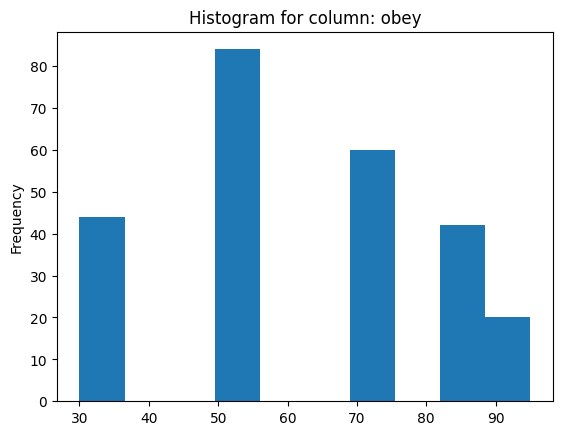

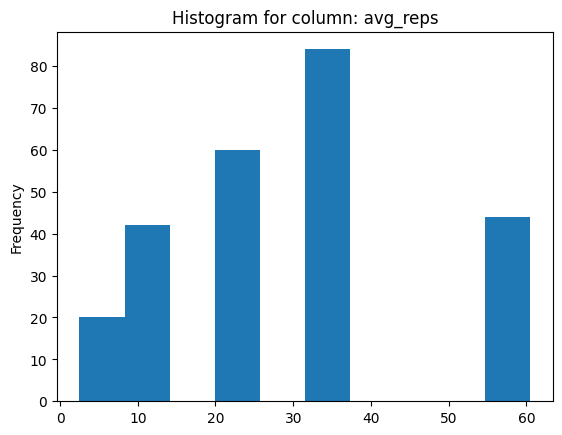

In [19]:
numeric_variables = [column for column, dtype in df.dtypes if dtype == "int" or dtype == "double"]
for num_col in numeric_variables:
  df_pandas = df.toPandas()  # Convert to pandas DataFrame
  df_pandas[num_col].plot.hist()
  plt.title(f"Histogram for column: {num_col}")
  plt.show()

Data looks pretty normal so no outlier removal is needed in our opinion, however it would be worth seeing how many outliers are detected.

# Outlier Detection

In [20]:
print("Number of rows prior to outliers removal:",df.count())

df_filtered = df

factor = 1.5
for name, data_type in df.dtypes:

    if data_type == "int" or data_type == "double":

        quantiles = df.approxQuantile(name, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        df_filtered = df_filtered.filter((col(name) >= lower_bound) & (col(name) <= upper_bound))

print("Number of rows after outliers removal:",df_filtered.count())
print("Percentage of rows that present outliers:",1-df_filtered.count()/df.count())

Number of rows prior to outliers removal: 250
Number of rows after outliers removal: 206
Percentage of rows that present outliers: 0.17600000000000005


As expected, there are no outliers in our data

# Data Storage

In [21]:
jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": "postgres", "password": "postgres"}


df.write \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", "org.postgresql.Driver") \
  .option("dbtable", "dog_intelligence_trusted") \
  .option("user", connectionProperties["user"]) \
  .option("password", connectionProperties["password"]) \
  .mode("append") \
  .jdbc(jdbc_url,"dog_intelligence_trusted")